<a href="https://colab.research.google.com/github/abdallahsrayeldine/french-english-nmt/blob/main/TranslationSeq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEQ2SEQ Translation Model with CAUTION MERCHISMS

# Installing Packages

In this section, we install the `Einops` and` Tensorflow-Text 'Packages. These packages are essential for data manipulation and natural language processing with tensorflow.

- `einops` is a python library that allows flexible and expressive manipulation of tensor axes. This Facilitates Dimensal Reordering and Data Processing in Neural Networks.
- `Tensorflow-Textt` is a tensorflow extension specificly designed for natural language processing (NLP). It provides various text preprocessing features and text encoding methods for use with nlp models.

In [ ]:
!pip install einops
!pip install tensorflow-text

# Libraries and modules

In this section, we import the libraries and modules Needed for the rest of the code. Here's an Explanation of the Main Imports:

- `Numpy` is a python library used to perform numbers and operations on multidimensal arumbs (real nurse, vectors, matrices, etc.).
- `Typing` is a python that module provids functionality for annotating types in code. It is used here to specific the types of function arguments and return values.
- `Einops` has already been explanéed previously during its installation.
- `MATPLOTLIB.PYPLOT 'is used to create visualizations, included graphs and studs.
- `MATPLOTLIB.TICKER 'IS USED to Manage Ticks and Labels on the Axes of Graphs.

Finlly, we import `Tensorflow` and` Tensorflow_Text`, which are the Main Libraries for Building Neural Network Models and Natural Language Processing With Tensorflow.

In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

# Data handling

## Verification class

In this sub-part, we define a class called `Shapechecker 'which helps us to check the forms of tensors when manipulating data. This class is particularly useful for ensuring the compatibility of dimensions when using neural networks models.

The Shapechecker 'class has a `` __call_ `` method, which takes a tensor and a list of axes names and performs a form check. If Tensorflow is in eager execution mode (interactive mode), the verification is carried out. Otherwise, nothing happens, which is practical when training models.

The verification process consists in analyzing the form of the tensor and comparing each dimension with the given names. If an axis name is encountered for the first time, its length is added to the class cache. If an axis has already been seen, its current length is compared to the old one. If the lengths do not correspond, an error is lifted to report a dimension conflict.

This class is a precious tool to make sure that the data complies with the specifications of the model, which makes it possible to avoid potential errors during training and prediction.


In [ ]:
# This class makes it possible to check the forms of the tensors when handling data
class ShapeChecker():
  def __init__(self):
    # Keep a cache of each axis name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    # If Tensorflow is not in eager mode, does nothing
    if not tf.executing_eagerly():
      return

    # Analyze the form of the tensor and compare it with the names given
    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      # If the new dimension is 1 and it must be disseminated, continues
      if (broadcast and new_dim == 1):
        continue

      # If the name of the axis is new, add its length to the cache
      if old_dim is None:
        self.shapes[name] = new_dim
        continue

      # If the new dimension does not correspond to the old one, lift an error
      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## Download the Dataset

In this sub-part, we download a file containing the data for our English-French translation model. The data comes from a text file in TSV format (TAB-SEPARATED VALUES), where each line represents a pair of sentences (English and French) separated by a tab.

We use the `Pathlib` library to manage file paths and the function` tf.keras.utils.get_file () `to download the file. The download link points to a commonly used translation dataset.

Once the file has been downloaded, we load the data by reading the text, dividing the lines and separating the English and French sentences to form lists of contexts (`Context_raw`) and targets (` Target_raw`). We then display the last French and English sentence to verify that the loading of the data has been carried out correctly.


In [ ]:
# Directly specific the path to the 'fra.txt' file
import pathlib
path_to_file = 'fra.txt'

# Load the data from the specific file
def load_data(path):
    # Read the text file
    text = pathlib.Path(path).read_text(encoding='utf-8')

    # Split the text into lines
    lines = text.splitlines()
    # Split Each Line Into Peirs Sentence (English, French)
    pairs = [line.split('\t') for line in lines]

    # Separate the English and French Sentences
    context_raw = [pair[0] for pair in pairs]
    target_raw = [pair[1] for pair in pairs]

    return context_raw, target_raw

# Load the data and display the last french and English sentence
context_raw, target_raw = load_data(path_to_file)
print(context_raw[-1])
print(target_raw[-1])


It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.
Il est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entreprise collaborative. Cependant, si nous encourageons les membres à produire des phrases dans leurs propres langues plutôt que d'expérimenter dans les langues qu'ils apprennent, nous pourrions être en mesure de réduire les erreurs.


## Training and validation datases

In this sub-part, we prepare the data for the training of our translation model. We divide the data into two sets: a training set and a validation set.

We define two sets of Booléens, `is_train` and` is_val`, using a uniform random distribution to distribute the examples between the two sets. About 80 % of the examples are intended for training (`is_train = true`) and the rest is intended for validation (` is_val = false`).

We then use these sets of Booléens to extract the indices from the training and validation examples from the lists `Context_raw` and` Target_raw`.

Finally, we create two Tensorflow datasets (`Train_raw` and` Val_raw`) using the indices corresponding to the training and validation sets. These datasets will be used to train and validate our translation model.

Note that we mix the examples when creating datasets to guarantee variability during training. We also bring together the examples in lots (`batch_size`) to improve the efficiency of the training process.

In conclusion, this part prepares the data for our English-French translation model, dividing data into training and validation sets, and transforming it into Tensorflow datasets ready to be used in the model.


In [ ]:
# Settings for data preparation
BUFFER_SIZE = len(context_raw)  # Buffer size for data mixing.
                               # Here, it is defined as the total length of the data to ensure a complete mixture.
BATCH_SIZE = 64                 # Number of examples to be treated at once during training.

# Create a table of Booleans to determine whether an example should be used for training.
# True value means that the example is intended for training, while a false value
# means that it is intended for validation. 80 % of examples are intended for training.
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

# Extract indices from training and validation examples.
train_indices = np.where(is_train)[0]
val_indices = np.where(~is_train)[0]

# Create datasets for training and validation using the previously determined indices.
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((np.array(context_raw)[train_indices], np.array(target_raw)[train_indices]))  # Create a dataset from paintings
    .shuffle(BUFFER_SIZE)  # Mix examples to guarantee variability during training
    .batch(BATCH_SIZE))    # Group the examples in lots (batches) for training
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((np.array(context_raw)[val_indices], np.array(target_raw)[val_indices]))  # Likewise for validation data
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

# Show some examples of the training set to check the format
for example_context_strings, example_target_strings in train_raw.take(1):  # Take a lot of the training dataset
  print(example_context_strings[:5])  # Show the first 5 contexts in the Lot
  print()
  print(example_target_strings[:5])  # Show the first 5 corresponding targets
  break

tf.Tensor(
[b"Let's not go to that restaurant again."
 b'I often played soccer when I was young.' b"You can't trust that guy."
 b'I apologize if I hurt your feelings.' b'My cats are my children.'], shape=(5,), dtype=string)

tf.Tensor(
[b"N'allons plus \xc3\xa0 ce restaurant."
 b"Je jouais souvent au football quand j'\xc3\xa9tais jeune."
 b'Tu ne peux pas croire ce type.'
 b"Je te prie de m'excuser si je t'ai bless\xc3\xa9."
 b'Mes chats sont mes enfants.'], shape=(5,), dtype=string)


# Pre -treatment

## Text standardization

In this sub-part, we carry out the pre-treatment of the text before using it to train our translation model. The purpose of pre -treatment is to normalize the text by eliminating the variations due to special and scrapyal characters, and transforming it into a tokens sequence.

We use the example of text "Are you an artificial intelligence researcher?" To illustrate the standardization process. We first use the function `tf_Text.normalize_utf8 ()` to decompose the characters into their compatible forms (NFKD) and transform them into a normalized unicode text. Then, we convert the text into tiny and delete any character which is not a letter from the English alphabet, a space, a point, a question mark, a comma or an exclamation point. We also add spaces around punctuation to separate them like separate tokens.

Finally, we add special tokens `[start]` and `[end]` around the text to indicate the beginning and the end of the tokens sequence. This step is essential for translation models so that they know when to start and finish the generation of text.

The pre -treatment standardizes the text and transforms it into a tokens sequence ready to be used by the translation model.


In [ ]:
# Example of text to transform
example_text = tf.constant('Êtes-vous un chercheur en Intelligence Artificielle ?')

# Show the initial text
print(example_text.numpy())
# Normalize the text to eliminate variations due to special or breakage characters, for example.
# Here, 'NFKD' is a unicode type of standardization that breaks down the characters in their compatible forms.
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc3\x8ates-vous un chercheur en Intelligence Artificielle ?'
b'E\xcc\x82tes-vous un chercheur en Intelligence Artificielle ?'


In [ ]:
# Function to transform the text: put it into tiny and separate punctuation
def tf_lower_and_split_punct(text):
  # Separate accentuated characters
  text = tf_text.normalize_utf8(text, 'NFKD')
  # Convert the text into a lowercase
  text = tf.strings.lower(text)
  # Keep the space, the letters from A to Z, and certain punctuation signs
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Delete superfluous spaces
  text = tf.strings.strip(text)

  # Add tokens start and end around the text
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

# Show the transformed example
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Êtes-vous un chercheur en Intelligence Artificielle ?
[START] etesvous un chercheur en intelligence artificielle  ? [END]


## Vectorization

In this sub-part, we carry out the vectorization of the textual data to prepare the entry of our translation model. Vectorization consists in converting the words into digital indices (tokens) using a vocabulary dictionary.

We define a maximum size for vocabulary (`Max_vocab_size`) which will limit the number of words taken into account for indexing. Then we create two text processors, one for the context (English) and the other for the target (French).

Each processor is a layer of text vectorization, which takes the normalized text as input (from the previous sub-part) and transforms it into tokens sequences. We use the function `tf.keras.layers.textvectorization` for this, by specifying the normalization function, the maximum size of the vocabulary and the option` ragged = true` to indicate that the sequences will have variable lengths.

Then, we "adapt" the text processors to the training data using the `.adapt () method` with the training datase. This allows text processors to learn vocabulary using training data.

We then display the first 10 words of the vocabulary to verify what the text processors have learned.

Finally, we use text processors to convert the examples of contextual chains into digital tokens sequences. This allows us to check if the tokenization is working properly and displaying a visual representation of the generated tokens and their mask (where the tokens are present and where they are not).

Vectorization prepares the textual data by converting the words into digital indices (tokens) for treatment with the translation model.


In [ ]:
# We define a maximum size for vocabulary.
max_vocab_size = 5000

# We create a text processor for the context (English). This processor is a layer
# text vectorization which allows the texts to be converted into tokens sequences.
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct, # Function to normalize the text
    max_tokens=max_vocab_size,            # Maximum vocabulary size
    ragged=True)                          # Returns a variable tensor

In [ ]:
# The text processor is "suitable" for training data. It's like adjusting a
# Tokenizer on data: he learns vocabulary.
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Displays the first 10 words of the vocabulary to check what he learned.
context_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('.'),
 np.str_('i'),
 np.str_('you'),
 np.str_('to'),
 np.str_('the'),
 np.str_('?')]

In [ ]:
# In the same way, we create a text processor for the target (French).
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

# Adapt the text processor to the targets of the training dataset.
target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('.'),
 np.str_('je'),
 np.str_('de'),
 np.str_('a'),
 np.str_('?'),
 np.str_('pas')]

In [ ]:
# Example of tokens generated by the text processor. We take some examples
# of contextual channels and we tokenize them.
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 145, 34, 48, 7, 13, 660, 160, 4, 3],
 [2, 5, 288, 959, 1205, 80, 5, 24, 358, 4, 3],
 [2, 6, 56, 434, 13, 618, 4, 3]]>

In [ ]:
# Converts tokens into words using the vocabulary. This allows us to
# Check if the tokenization is working properly.
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] lets not go to that restaurant again . [END]'

Text(0.5, 1.0, 'Mask')

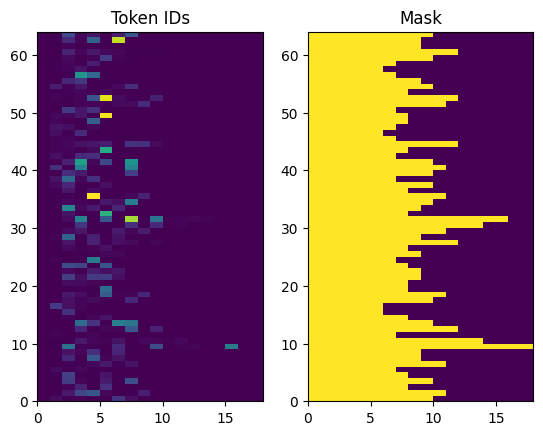

In [ ]:
# Displays a visual representation of the IDS of Tokens and their mask.
# The mask indicates where the tokens are present (value 1) and where they are not (value 0).
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [ ]:
# Function to process text before providing it to the model. She converts
# the context and the target in tokens, and also creates inputs and exits
# for the target (by shifting from a token).
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out

# Apply this treatment function to training and validation dataets.
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
# Displays an example of data processed to check the structure of tokens.
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[  2   5  22 289  30 710   4   3   0   0]

[   2    5   29 1188    6   20   52   46  157    4]
[   5   29 1188    6   20   52   46  157    4    3]


# The encoder/decoder model

In [ ]:
# The number of units for encoding and attention layers are defined.
UNITS = 256

In this part, we define the English-French translation model using the architecture of encoder-decoder. This model is an architecture commonly used for translation and text generation tasks.

We use layers of encoding and attention to capture semantic information from input sentences and generate output translations.

- `Units` represents the number of units (neurons) for layers of encoding and attention. This parameter is defined at 256, but it can be adjusted according to the needs and complexity of the model.

The model of encoder-decooder is a powerful architecture which can be led to generate high-quality translations according to the pairs of training sentences. The combination of the vectorization of the text, the pre -treatment and the architecture of the model will make it possible to obtain an effective and precise translation system.


## Encoder

In this sub-part, we implement the personalized encoder layer. The encoder transforms a text sequence into a sequence of vectors. It uses two main components: the embedding layer and a bidirectional RNN layer.

- The embedding layer (`self.embedding`) is used to convert tokens (words) into dense vectors. This makes it possible to represent the text continuously and facilitates learning the relationships between words. The embedding is specified by the number of units (`units`) that each word will be represented.

- The bidirectional RNN layer (`Self.rnn ') treats sequentially embedding vectors. She takes the vectors from Embedding as an entry and returns a sequence of hidden states, making it possible to capture the contextual information in the two directions (front and rear) of the text. The `Merge_Mode option = 'Sum'' means that the outputs of the two directions are summoned.

The method of the encoder takes an input sequence `X 'and performs the following operations:

1. Conversion of tokens into embedding vectors using the embedding layer.
2. Treatment of embedding vectors with the bidirectional RNN layer (`Self.rnn`).
3. Reference of the processed sequence.

The `Convert_input` method is used to convert a raw text to its encoded representation using the encoder. It takes a text as a text, converts it to tokens and passes it to the encoder to obtain the corresponding embedding vectors.


In [ ]:
# The encoder is a personalized layer that converts a text sequence into a sequence of vectors.
class Encoder(tf.keras.layers.Layer):
  # Initialization of the encoder
  def __init__(self, text_processor, units):
    # Initialization of the superclass
    super(Encoder, self).__init__()
    # Text processing is necessary to tokenize the text
    self.text_processor = text_processor
    # The size of the vocabulary determines the number of different words that can be treated
    self.vocab_size = text_processor.vocabulary_size()
    # The number of units in the RNN and Embedding layers
    self.units = units

    # The embedding layer converts tokens (words) into vectors
    # This allows a dense representation of the text
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

    # The RNN layer (Gru here) deals with these sequential vectors
    # Bidirectional means that the RNN treats the text in the two directions (front and rear)
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units, return_sequences=True, recurrent_initializer='glorot_uniform'))

  # This method is called to treat an input sequence X
  def call(self, x):
    # An instance to check the shape of the tensors
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # Conversion of tokens into vectors
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # Treatment of vectors with RNN
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # Refer the treated sequence
    return x

  # This method converts a raw text into its encoded representation
  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the entry sequence

# Instancing of the encoder
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Tokens de contexte, forme (batch, s): {ex_context_tok.shape}')
print(f'Sortie de l\'encodeur, forme (batch, s, units): {ex_context.shape}')

Tokens de contexte, forme (batch, s): (64, 18)
Sortie de l'encodeur, forme (batch, s, units): (64, 18, 256)


## The attention layer

In this sub-part, we define the personalized attention layer (`Crossatant '). This layer allows the model to be focused on certain parts of the context during translation.

- The layer uses `tf.keras.layers.multihedatet '(` self.mha`) which is a method of attention to process information in several ways at the same time.
- `Self.Layernorm` is a layer of normalization which improves the stability of learning.
- `Self.add` combines the outputs of attention with the previous outings.

The method of the attention layer takes a sequence `X 'as input and the context` context. She performs the following operations:

1. Obtaining attention weights and output using `TF.Keras.Layers.Multiheadatet '.
2. Combination of outputs using `Self.add`.
3. Normalization of outputs using `Self.Layernorm`.

This layer is used in the decoder to focus on the relevant context during the generation of translation.


In [ ]:
# This layer provides a attention mechanism to focus on certain parts of the context during the translation
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    # Multiheadatetation is a method of attention that processes information in several ways both
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    # Obtaining attention weights and exit
    attn_output, attn_scores = self.mha(query=x, value=context, return_attention_scores=True)
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    # Combination of outings
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

attention_layer = CrossAttention(UNITS)

# Assist the encoded tokens to check the operation of the attention layer
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(), output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)
result = attention_layer(ex_tar_embed, ex_context)

# Display of forms to understand the transformation of data
print(f'Séquence de contexte, forme (batch, s, units): {ex_context.shape}')
print(f'Séquence cible, forme (batch, t, units): {ex_tar_embed.shape}')
print(f'Résultat de l\'attention, forme (batch, t, units): {result.shape}')
print(f'Poids de l\'attention, forme (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Séquence de contexte, forme (batch, s, units): (64, 18, 256)
Séquence cible, forme (batch, t, units): (64, 17, 256)
Résultat de l'attention, forme (batch, t, units): (64, 17, 256)
Poids de l'attention, forme (batch, t, s):    (64, 17, 18)


In [ ]:
# Calculate the sum of the weight of attention to verify that they summon well to 1
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 0.9999998 , 0.9999999 , 0.9999999 , 0.9999998 ,
       1.        , 0.99999994, 1.        , 1.        , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

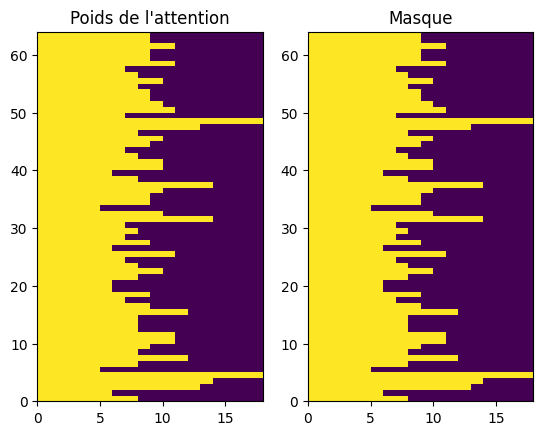

In [ ]:
# Visualization of attention weights

# Recovery of attention weights from the last attention layer
attention_weights = attention_layer.last_attention_weights
# Creation of a mask to exclude tokens which are zeros (that is to say padding)
mask=(ex_context_tok != 0).numpy()

# Creation of a figure with 2 subpups side by side
plt.subplot(1, 2, 1)
# Display of attention weights multiplied by the mask (to delete the display of paddings)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Poids de l\'attention')

plt.subplot(1, 2, 2)
# Mask display itself to view the actually hidden regions
plt.pcolormesh(mask)
plt.title('Masque');

## The decoder

In this sub-part, we implement the class of the personalized decoder. The decoder takes the encoded context and generates a target sequence (translation) word by word.

The decoder has several important components:

- `Self.word_to_id` and` Self.id_To_Word` are layers of conversion of words into unique identifiers and vice versa. They are used to manage the vocabulary of the target sequences.

- `Self.start_token 'and` Self.end_token' represent the identifiers of the tokens of the start and end of the sequence. They are used to indicate when to start and stop the translation generation.

- `Self.embedding` is an embedding layer to convert tokens identifiers into embedding vectors.

- `Self.rnn` is an RNN layer (GRU) used to treat target sequences.

- `Self. Attention 'is the attention layer (` Crossatant') used to focus on the context during the generation of the translation.

- `SELF.Output_layer` is a dense layer which predicts the next token according to the outputs of the decoder.

The method `Call` Du Décumer takes the context encoded in the context of context, the input tokens` X`, the state of the decoder `State 'and an option` Return_state`. She performs the following operations:

1. Conversion of input tokens into embedding vectors using the embedding layer.
2. Treatment of the input sequence with the RNN layer to obtain the X 'output sequence.
3. Using the attention layer to focus on the relevant context during the generation of translation.
4. Prediction of the next token with the output layer.

The `Get_initial_State` method is used to initialize the condition of the decoder before translation. It returns the token at the start for each batch sequence, initializes the "Done" variable to false for all the sequences and returns the initial state of the RNN.

The `Tokens_To_Text 'method converts the tokens to text, using the reverse dictionary` Self.id_to_word`. She joins the words to form a sentence and removes the tokens at the start and end.

The `Get_Next_token` method is used to predict the next token during the translation generation. It takes the context asset, the next token, the state of the decoder, the "Done" variable (indicating if a sequence is finished) and a temperature option for the random generation. If the temperature is equal to 0, the token is chosen with the highest probability (deterministic mode). Otherwise, the token is chosen randomly depending on the logits (stochastic mode). This method is used to iterate on tokens and generate the complete word translation by word.


In [ ]:
# Definition of the decoder class
class Decoder(tf.keras.layers.Layer):
  # Define a class method to dynamically add methods to the class
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  # Initialization of the decoder class
  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()  # Initializing the Layer Superclass
    # Text Processor to treat target sequences
    self.text_processor = text_processor
    # Vocabulary size of target sequences
    self.vocab_size = text_processor.vocabulary_size()
    # Word conversion into unique identifiers
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    # Reverse conversion of unique identifiers in words
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    # Identify the start and end token
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')
    # Define the number of units for the RNN and the embedding layer
    self.units = units
    # Convert tokens identifiers into embedding vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)
    # RNN to treat target sequences
    self.rnn = tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    # Attention layer to focus on the relevant context
    self.attention = CrossAttention(units)
    # Outing layer to predict the next token
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
# The "call" method to treat sequences with the decoder
@Decoder.add_method
def call(self, context, x, state=None, return_state=False):
  shape_checker = ShapeChecker()  # Utility to check the dimensions of the tensors
  # Check the dimensions of the input Tensor
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')
  # Convert tokens identifiers into embedding vectors
  x = self.embedding(x)
  shape_checker(x, 'batch t units')
  # Treat the sequence with the RNN
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')
  # Use the attention layer to focus on the relevant context
  x = self.attention(x, context)
  # Save attention weights for possible visualization
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')
  # Predict the next token with the output layer
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')
  # Return either the logits with the state or just the logits according to "Return_state"
  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
# Instantly decoder with the appropriate parameters
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
# Test the decoder with an example of a context and an entry sequence
logits = decoder(ex_context, ex_tar_in)

# Show tense forms to make sure they are correct
print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'cross_attention_1' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


encoder output shape: (batch, s, units) (64, 18, 256)
input target tokens shape: (batch, t) (64, 17)
logits shape shape: (batch, target_vocabulary_size) (64, 17, 5000)


In [ ]:
# Definition of additional methods for the decoder

# This method initializes the state of the decoder before the translation
@Decoder.add_method
def get_initial_state(self, context):
  # Get batch size from the context
  batch_size = tf.shape(context)[0]
  # Create the starting token for each batch sequence
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  # Initializing the "Done" variable to false for all sequences
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  # Convert the starting tokens to embeddings
  embedded = self.embedding(start_tokens)
  # Return the starting token, the "Done" variable, and the initial state of the RNN
  # Fix: call get_initial_state with the batch size
  return start_tokens, done, self.rnn.get_initial_state(batch_size=batch_size)[0]

# Convert tokens into text
@Decoder.add_method
def tokens_to_text(self, tokens):
  # Convert tokens identifiers into words
  words = self.id_to_word(tokens)
  # Join the words to form a sentence
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  # Remove the departure and end tokens
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

# Predict the next token
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  # Obtain the logits and the condition of the decoder
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  # If the temperature is equal to 0, choose the token with the highest probability
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    # Otherwise, choose a token randomly depending on the logits
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If an end token is generated, update the "Done" variable
  done = done | (next_token == self.end_token)
  # If a sequence is finished, produce only padding
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Initialize the variables for the translation loop
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

# Loop to generate a translation
for n in range(10):
  # Get the next token
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the tokens list
  tokens.append(next_token)

# Concatenate all tokens to obtain the complete translation
tokens = tf.concat(tokens, axis=-1) # (Batch, t)

# Convert tokens into text
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'batiment plat memes cacher portestu cacha cinema my compose avion',
       b'merveilleuse jeunes calmes vin allumette tatouage fais excellent beurre difficulte',
       b'partirai supporte collier lexplosion clefs mignonne traduction moque damerique rendue'],
      dtype=object)

# The model

In this part, we create a class `Translator` to combine the encoder and the decoder in a complete translation model. The class `Translator` inherits from` tf.keras.model ', which allows us to define the method `Calle' to execute the translation.

The `Calle method takes a tuple` inputs "containing the context and the target sequence` X '. She performs the following operations:

1. Execute the encoder to obtain the context encoded from the input context (`Context = Self.coder (Context)`).
2. Execute the decoder to obtain the output logits using the encoded context and the target sequence (`Logits = self.Decoder (Context, x)`).

We also define a translation method (`translate`) for the translator 'model. This method takes a raw text as input and returns its translation using the trained model. It uses the encoder to convert the raw text to its encoded representation (`context = self.coder.convert_input (texts)`), then uses the decoder to generate the word translation by using the method `get_next_token 'of the decoder.

We also add a method to visualize attention during the translation (`Plot_Atation`). This method takes a raw text as input, uses the model to translate it, and displays attention weights on a matrix to visualize which parts of the context were used to generate each word of the translation.


In [ ]:
# Translator class to combine the encoder and the decoder
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and the decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  # Definition of the "Call" method to execute the translation
  def call(self, inputs):
    context, x = inputs
    # Execute the encoder to obtain the encoded context
    context = self.encoder(context)
    # Execute the decoder to obtain the logits
    logits = self.decoder(context, x)

    # Deletion of the Keras mask (specific note note, probably linked to a technical constraint)
    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
# Creation of an instance of the Translator model and test on an example
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'decoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Context tokens, shape: (batch, s, units) (64, 18)
Target tokens, shape: (batch, t) (64, 17)
logits, shape: (batch, t, target_vocabulary_size) (64, 17, 5000)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


## Training

In this sub-part, we define the personalized loss and precision functions for the model, adapted to the training process of the sequence sequence model.

- The `Masked_loss' function calculates the loss by ignoring padding tokens. This is necessary because the target sequences can have different lengths and are supplemented by padding tokens. By masking these padding tokens, the loss is only calculated on the relevant tokens.

- The `Masked_acc` function calculates the precision by also ignoring padding tokens. Like masked loss, masked accuracy ensures that metric is calculated only on relevant tokens and ignores padding tokens.

Then we comply the model using an optimizer, the masked loss function and the masked metrics. We use Adam optimizer for weight updates, and we use masked loss and precision functions to assess the model errors and monitor your performance during training.

Finally, we assess the performance of the model on a validation dataset to see its initial performance before training.

We then use the `FIT method to train the model on training data. We repeat the training data for several eras and use validation to monitor performance. We also use the TF.Keras.keras.Callbacks.earlyStopping` Reminder to stop training if the loss does not improve for a number of consecutive times. This avoids unnecessary switching on and allows us to choose the best model based on performance on validation data.


In [ ]:
# Define the loss and precision functions for the model


# The "masked_loss" function is designed to calculate the loss by ignoring padding tokens.
# This is necessary because when training a sequence sequence model,
# The sequences can have different lengths and are supplemented by padding tokens.
# By masking these padding tokens, we make sure that the loss is only calculated on the relevant tokens.

def masked_loss(y_true, y_pred):
    # Calculation of the loss for each batch element
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the loss on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # We return the result
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

# The "masked_acc" function is designed to calculate precision by also ignoring padding tokens.
# Like masked loss, masked accuracy ensures that metric is calculated only on
# The relevant tokens and ignores padding tokens.

def masked_acc(y_true, y_pred):
    # Calculation of the loss for each batch element
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
# Compile the model with an optimizer, a loss function and metrics

# The compile method configures the model learning process
model.compile(optimizer='adam', # Uses the "Adam" optimizer for weight updates
              loss=masked_loss, # Personalized loss function to assess the errors of the model
              metrics=[masked_acc, masked_loss]) # Metrics to monitor performance during training

In [ ]:
# Calculate the target vocabulary size

# Obtain vocabulary size from the text processor
vocab_size = 1.0 * target_text_processor.vocabulary_size()

# Calculate the expected loss and precision for a model that predicts random outings
{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': np.float32(8.517193), 'expected_acc': 0.0002}

In [ ]:
# Evaluate the performance of the model on a validation dataset

# Assesses the current performance of the validation data model
model.evaluate(val_ds, steps=15, return_dict=True)

# Make the model

# Use the "Fit" method to train the model on training data
history = model.fit(
    train_ds.repeat(), # Repeat training data for several passages (eras)
    epochs=35, # Number of training times
    steps_per_epoch = 100, # Number of lots treated before going to the next time
    validation_data=val_ds, # Data used for validation
    validation_steps = 20, # Number of validation lots to be used in each era
    callbacks=[ # Mechanisms to intervene during training
        tf.keras.callbacks.EarlyStopping(patience=3)]) # Stop training if the loss does not improve for 3 consecutive times

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 392ms/step - loss: 8.5267 - masked_acc: 2.3612e-05 - masked_loss: 8.5267
Epoch 1/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - loss: 5.7757 - masked_acc: 0.2025 - masked_loss: 5.7757 - val_loss: 3.9759 - val_masked_acc: 0.3637 - val_masked_loss: 3.9759
Epoch 2/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 3.7926 - masked_acc: 0.3892 - masked_loss: 3.7926 - val_loss: 3.2914 - val_masked_acc: 0.4412 - val_masked_loss: 3.2914
Epoch 3/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 3.1652 - masked_acc: 0.4588 - masked_loss: 3.1652 - val_loss: 2.8226 - val_masked_acc: 0.4978 - val_masked_loss: 2.8226
Epoch 4/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 2.7317 - masked_acc: 0.5040 - masked_loss: 2.7317 - val_loss: 2.3953 - val_masked_acc: 0.5596 - val_masked_loss: 2.3953
Epoch 5/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 2.3965 - masked_acc: 0.5572 - masked_loss: 2.3965 - val_loss: 2.1818 - val_masked_acc: 0.5830 - val_masked_loss:

## Visualization of results

In this sub-part, we visualize the results of the training by displaying the loss and precision curves during training. This allows us to see how loss and precision evolve as and when the times, which is useful for assessing the performance of the model.


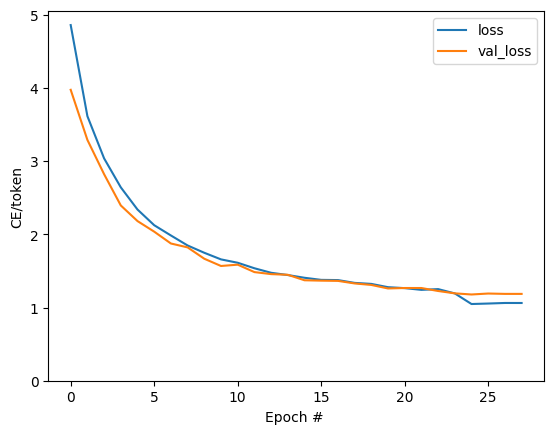

In [ ]:
# Show the loss curve during training
plt.plot(history.history['loss'], label='loss') # Loss of training curve
plt.plot(history.history['val_loss'], label='val_loss') # Validation loss curve
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch # ') # Axis of abscissa
plt.ylabel('CE/token') # Order axis
plt.legend()

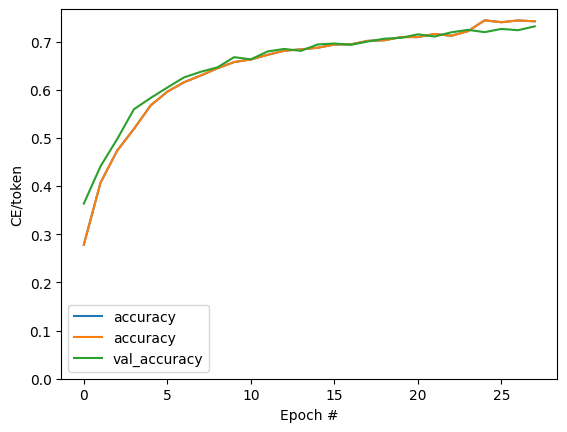

In [ ]:
# Show the precision curve during training
plt.plot(history.history['masked_acc'], label='accuracy') # Training precision curve
# Show the precision curve during training
plt.plot(history.history['masked_acc'], label='accuracy') # Training precision curve
plt.plot(history.history['val_masked_acc'], label='val_accuracy') # Validation precision curve
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Translation

Finally, in this sub-part, we add a translation method to the class `Translator`. This method takes on a raw text as input and returns its translation using the trained model.

We use the encoder to convert raw text to its encoded representation. Then, we initialize the variables for the generation loop of tokens and iterons to generate the next token until reaching the maximum length of the output or until all the sequences are finished. We use the `Get_Next_Token 'method of the decoder to generate the next token according to the attention weights calculated by the attention layer. Finally, we concrete the tokens lists to obtain the complete translation and send it back.

We also add a method `Plot_Antet 'to view the weights of attention during the translation. This method takes a raw text as input, uses the model to translate it, and displays attention weights on a matrix to visualize which parts of the context were used to generate each word of the translation.


In [ ]:
# Add a translation method to the Translator class

@Translator.add_method
def translate(self,
              texts, *,
              max_length=50, # Maximum output length
              temperature=0.0): # Parameter to control the diversity of the output
  # Converts the raw text into encoded representation
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0] # Obtain the prize size

  # Initializing the variables for the tokens generation loop
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the following token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)

    # Add the token and attention weights to their respective lists
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    # Stop the generation if all the texts are finished
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Concaten the lists of tokens and weight of attention
  tokens = tf.concat(tokens, axis=-1)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)

  # Convert tokens into text
  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
# Test the translation method

# Translate an example of a sentence
# result = model.translate(['I love apples'])
# # Show the translation
# result[0].numpy().decode()

result = model.translate(['i love you'])
# Show the translation
result[0].numpy().decode()

'je vous adore etre en train de vous . '

In [ ]:
# Add a method to view attention when translation

@Translator.add_method
def plot_attention(self, text, **kwargs):
  # Make sure the text is a chain
  assert isinstance(text, str)
  # Obtain the translation of the text
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0] # Recover attention

  # PRETRATION OF TEXTS for display
  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()
  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  # Create a graphic to view attention weights
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis', vmin=0.0)
  fontdict = {'fontsize': 14}
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.set_xlabel('Texte en entrée')
  ax.set_ylabel('Texte en sortie')

## Visualize attention

In this sub-part, we test the visualization of attention weights during the translation. We use the method `Plot_Antet 'of the model to display attention weights between the input text and the generated translation. We first test on a short example, then on a longer text.


<ipython-input-39-cd31b9226615>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-39-cd31b9226615>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


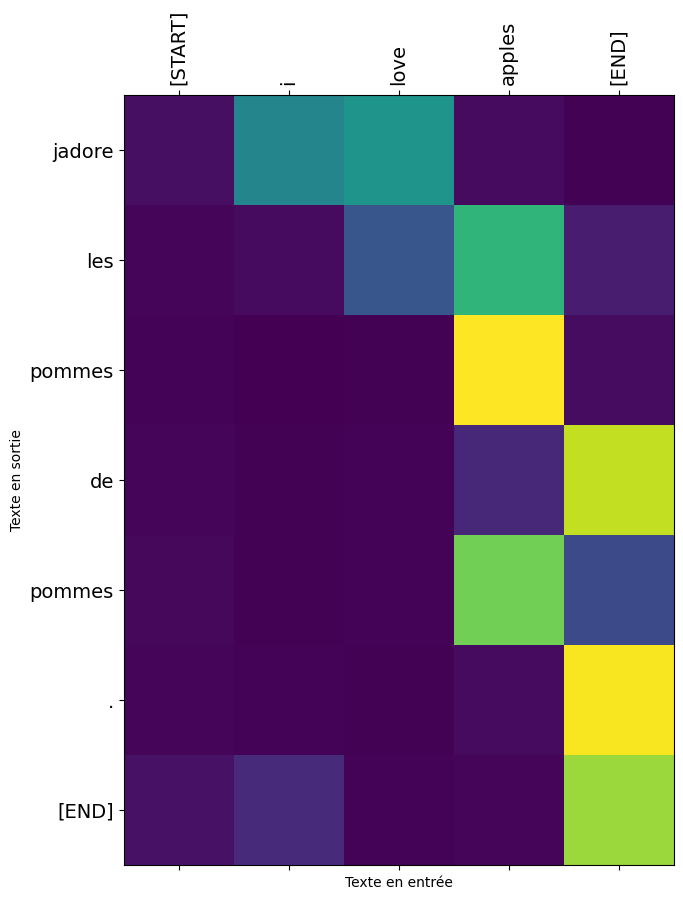

In [ ]:
# Test the visualization of attention
model.plot_attention('i love apples')

Expected outing: \ n Il est peut-être impossible d'obtenir un Corpus complètement dénué de
fautes, étant donnée la nature de ce type d'entreprise collaborative.
Cependant, si nous encourageons les membres à produire des phrases
dans leurs propres langues plutôt que d'expérimenter dans les langues
qu'ils apprennent, nous pourrions être en mesure de réduire les
erreurs.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
<ipython-input-39-cd31b9226615>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-39-cd31b9226615>:25: UserWarning: set_ticklabels() should only be used with a fixed number of tic

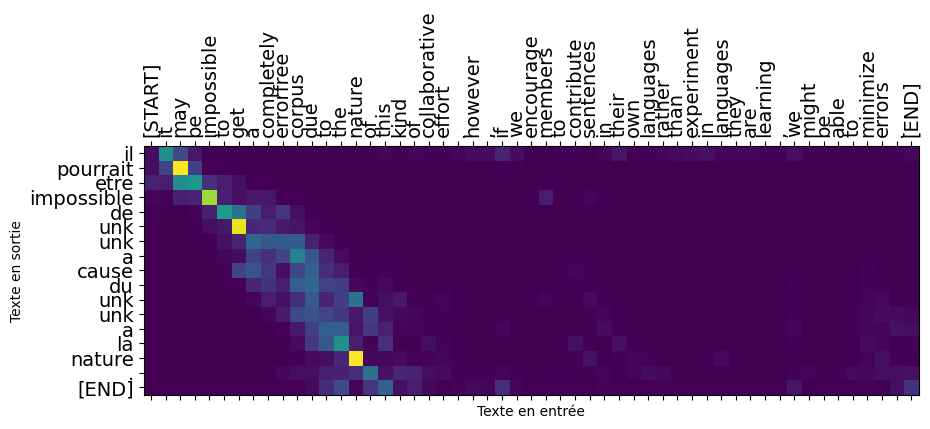

In [ ]:
# Recover a long text for the test
long_text = context_raw[-1]

# Show the expected translation
import textwrap
print('Expected outing: \ n', '\n'.join(textwrap.wrap(target_raw[-1])))

# Test the visualization of attention on the long text
model.plot_attention(long_text)

In [ ]:
# Prepare some entries for additional tests
inputs = [
'i love fish'
]

for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

jadore les poissons [UNK] . 



/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


# Results analysis

In this part, we examine the results of the training and perform different analyzes on the model.


## Histogram of gradients

This stud will give you an idea of ​​the magnitude of the gradients during training.


We display a histogram of gradient standards to get an idea of ​​their magnitude during training. This can help us check whether the gradients are too small or too large, which could affect the convergence of training.


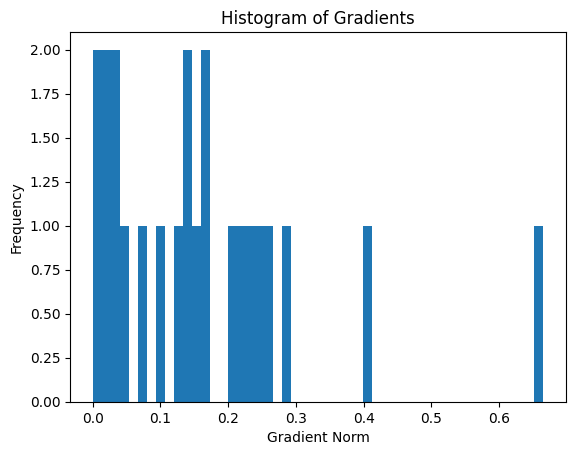

In [ ]:
def plot_gradient_histogram(model):
    with tf.GradientTape() as tape:
        logits = model((ex_context_tok, ex_tar_in))
        loss_value = masked_loss(ex_tar_out, logits)

    grads = tape.gradient(loss_value, model.trainable_variables)
    gradients = [tf.norm(grad).numpy() for grad in grads if grad is not None]

    plt.hist(gradients, bins=50)
    plt.xlabel('Gradient Norm')
    plt.ylabel('Frequency')
    plt.title('Histogram of Gradients')
    plt.show()

# Example of use after each era or iteration:
plot_gradient_histogram(model)


## Loss curve by Epoch


We trace a curve to visualize the evolution of the loss of training and the loss of validation over the eras. This allows us to see how loss changes during training and identify any over-learning or under-learning trend.


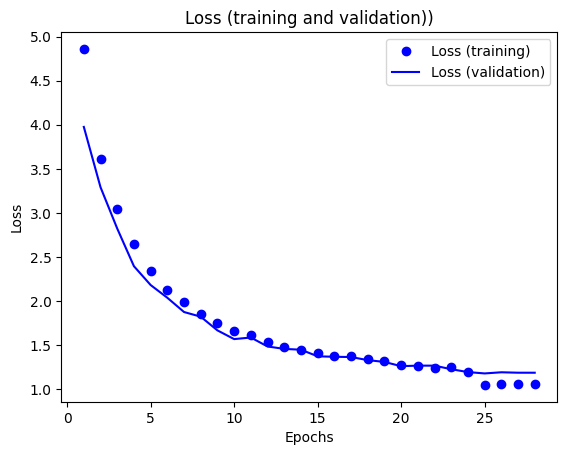

In [ ]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Loss (training)')
    plt.plot(epochs, val_loss, 'b', label='Loss (validation)')
    plt.title('Loss (training and validation))')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

## Loss curve depending on time

We record the time required for each training period and train a curve to visualize the loss according to the elapsed time. This allows us to see if the loss gradually decreases over time and if training is progressing effectively.


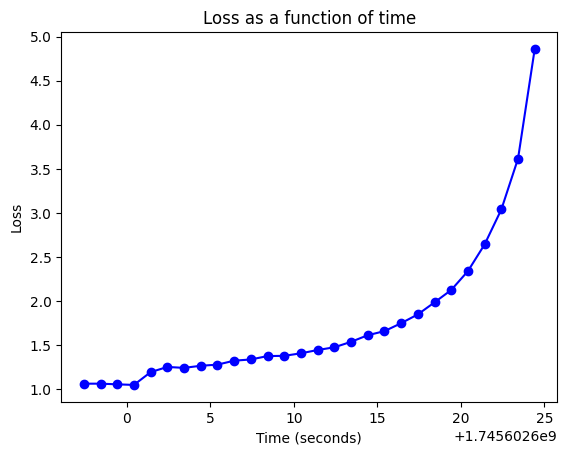

In [ ]:
import time

def plot_loss_vs_time(history):
    loss = history.history['loss']
    timestamps = [time.time() - start_time for start_time in history.epoch]
    plt.plot(timestamps, loss, 'bo-')
    plt.title('Loss as a function of time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Loss')
    plt.show()

plot_loss_vs_time(history)

## Histogram of losses distribution


We draw a histogram to view the distribution of loss values ​​during training. This can give us an idea of ​​the variability of the loss and stability of training.


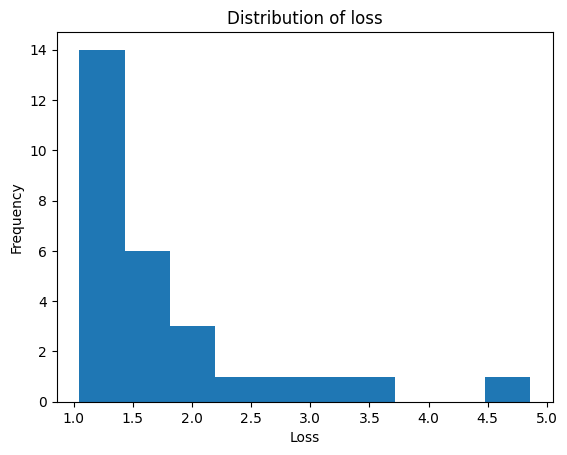

In [ ]:
def plot_loss_distribution(history):
    loss = history.history['loss']
    plt.hist(loss, bins=10)
    plt.title('Distribution of loss')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.show()

plot_loss_distribution(history)

## Recording of results


Finally, we record the trained model using the Keras Save` method, as well as the training history in the form of a pickle file to be able to reuse them later.

In [ ]:
import pickle

# Save the model with the .Keras extension
model.save('eng_to_french.keras')

# Save history
with open('historique.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
from ipywidgets import widgets, Layout, VBox, HBox
from IPython.display import display, HTML

# Custom CSS for consistent styling
custom_css = '''
<style>
.widget-text input[type="text"] {
    font-size: 20px;  /* Larger font for input fields */
    padding: 5px;     /* Breathing room inside inputs */
}
.widget-label {
    font-size: 18px;  /* Larger font for labels */
}
.widget-button {
    font-size: 18px;  /* Larger font for button */
}
</style>
'''
display(HTML(custom_css))

# Centered title using HTML
title = HTML('<h2 style="font-family: Arial, sans-serif; text-align: center;">Enter Two Strings</h2>')

# Text input fields with wider layout
string1_input = widgets.Text(layout=Layout(width='50%'))

# Styled and centered save button
save_button = widgets.Button(
    description='Translate',
    button_style='success',  # Green button
    layout=Layout(width='150px')  # Fixed width for symmetry
)

# Output area for confirmation
output = widgets.Output()

# Function to save strings when the button is clicked
def on_save_button_clicked(b):
    print("Output: ")
    result=model.translate([string1_input.value])
    print(result[0].numpy().decode())

# Link the function to the button
save_button.on_click(on_save_button_clicked)

# Center the input fields horizontally
input_box = HBox(
    [string1_input],
    layout=Layout(justify_content='center', margin='10px 0')
)

# Center the button horizontally
title = widgets.HTML('<h2 style="text-align: center;">Enter your text for translation</h2>')

button_box = HBox(
    [save_button],
    layout=Layout(justify_content='center', margin='10px 0')
)

# Organize everything in a vertical box, fully centered
vbox = VBox(
    [title, input_box, button_box, output],
    layout=Layout(
        align_items='center',  # Centers all children horizontally
        padding='10px',        # Adds padding around the container
        width='100%'           # Ensures the container spans the available width
    )
)

# Display the GUI
display(vbox)


Output: 
bonjour ! 
Output: 
les pommes ! 
